In [1]:
#Importing libraries for CNN model with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from collections import deque
import gymnasium as gym

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
class PPO:
    def __init__(self) -> None:
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(self.device)
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        self.training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=self.tf)
        self.trainloader = torch.utils.data.DataLoader(self.training_set, batch_size=64, shuffle=True, num_workers=2)
        self.weight_pack_size = 5
        self.episodes = 100
        self.mutation_rate = 0.1
        self.mutation_scale = 0.1
        self.loss = nn.CrossEntropyLoss()
    
    # Initialize algae population
    def initialize_weight_pack(self):
        population = []
        for _ in range(self.weight_pack_size):
            model = Network().to(self.device)
            model.apply(self.initialize_weights)
            population.append(model.state_dict())
        return population


    def initialize_weights(self, model):
        if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
            nn.init.xavier_uniform_(model.weight.data)
    
    # Define fitness evaluation function
    def evaluate_accuracy(self, model, criterion, dataloader):
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy
    
    # Update algae positions
    def update_positions(self, weight_pack, fitness_scores):
        # Calculate probabilities based on fitness scores
        total_fitness = sum(fitness_scores)
        probabilities = [score / total_fitness for score in fitness_scores]
        
        # Update positions based on probabilities
        new_weight_pack = []
        for _ in range(self.weight_pack_size):
            parent_w1 = random.choices(weight_pack, weights=probabilities)[0]
            parent_w2 = random.choices(weight_pack, weights=probabilities)[0]            
            new_weight_pack.append(self.mutate(self.crossover(parent_w1, parent_w2)))
        return new_weight_pack

    # Crossover operation
    def crossover(self, parent_w1, parent_w2):
        child = {}
        for key in parent_w1.keys():
            if random.random() < 0.5:
                child[key] = parent_w1[key].clone()
            else:
                child[key] = parent_w2[key].clone()
        return child

    # Mutation operation
    def mutate(self, child):
        for key in child.keys():
            if random.random() < self.mutation_rate:
                mutation_tensor = torch.randn_like(child[key]) * self.mutation_scale
                child[key] += mutation_tensor
        return child
    
    def load_model(self, model_path):
        model = Network().to(self.device)
        model.load_state_dict(torch.load(model_path))
        return model
    
    def train(self):
        # Initialize algae population
        population = self.initialize_weight_pack()

        # Lists to store generation and best fitness scores
        episode_list = []
        best_accuracy_list = []

        for episode in range(self.episodes):
            # Evaluate fitness of algae population
            accuracy_scores = []
            for model_weights in population:
                model = Network().to(self.device)
                model.load_state_dict(model_weights)
                accuracy = self.evaluate_accuracy(model, self.loss, self.trainloader)
                accuracy_scores.append(accuracy)
            
            # Update algae positions
            population = self.update_positions(population, accuracy_scores)

            # Store generation and best fitness score for plotting
            episode_list.append(episode+1)
            best_accuracy_list.append(max(accuracy_scores))

            print(f"Episode {episode+1}: Best Accuracy = {max(accuracy_scores)}")

        # Select the best model from the final population
        best_model_weights, _ = max(zip(population, accuracy_scores), key=lambda x: x[1])
        best_model = Network().to(self.device)
        best_model.load_state_dict(best_model_weights)
        torch.save(best_model.state_dict(), f"best_model_accuracy_{episode+1}.pt")
        
        return episode_list, best_accuracy_list
        

In [4]:
ppo_model = PPO()
generation_list, best_fitness_list = ppo_model.train()

cuda
Episode 1: Best Accuracy = 0.10658333333333334
Episode 2: Best Accuracy = 0.1126
Episode 3: Best Accuracy = 0.13903333333333334
Episode 4: Best Accuracy = 0.14566666666666667
Episode 5: Best Accuracy = 0.16865
Episode 6: Best Accuracy = 0.13903333333333334
Episode 7: Best Accuracy = 0.16235
Episode 8: Best Accuracy = 0.1619
Episode 9: Best Accuracy = 0.12263333333333333
Episode 10: Best Accuracy = 0.13068333333333335
Episode 11: Best Accuracy = 0.13068333333333335
Episode 12: Best Accuracy = 0.13866666666666666
Episode 13: Best Accuracy = 0.13866666666666666
Episode 14: Best Accuracy = 0.1031
Episode 15: Best Accuracy = 0.11595
Episode 16: Best Accuracy = 0.11595
Episode 17: Best Accuracy = 0.14826666666666666
Episode 18: Best Accuracy = 0.1291
Episode 19: Best Accuracy = 0.14826666666666666
Episode 20: Best Accuracy = 0.12483333333333334
Episode 21: Best Accuracy = 0.14096666666666666
Episode 22: Best Accuracy = 0.13775
Episode 23: Best Accuracy = 0.14603333333333332
Episode 24: 

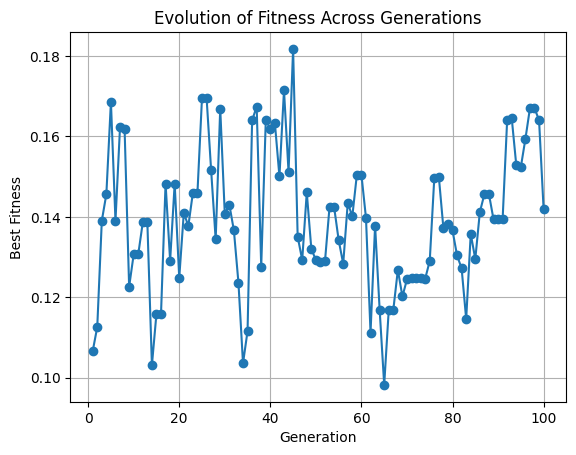

In [5]:
plt.plot(generation_list, best_fitness_list, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Evolution of Fitness Across Generations')
plt.grid(True)
plt.show()